# Change signal

Assessment of model change signal over the future period relative to the historical.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

import utils

In [2]:
def calc_change_signal(da_future, da, var):
    """Calculate the difference in the change signal between GCM and RCM """
    
    if var == 'pr':
        future_annual_mean = da_future.groupby('time.year').sum(dim="time").mean(dim='year')
        base_annual_mean = da.groupby('time.year').sum(dim="time").mean(dim='year')
        change_signal = ((future_annual_mean - base_annual_mean) / base_annual_mean) * 100
    else:
        future_annual_mean = da_future.groupby('time.year').mean(dim="time").mean(dim='year')
        base_annual_mean = da.groupby('time.year').mean(dim="time").mean(dim='year')
        change_signal = future_annual_mean - base_annual_mean
    
    return change_signal

In [3]:
def get_data(var, gcm, rcm):
    """Get data needed for the evaluation"""

    assert gcm in ['CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']

    start_date = '1980-01-01' 
    end_date = '2019-12-31'
    start_date_future = '2060-01-01'
    end_date_future = '2099-12-31'

    da_dict = {}

    da_dict['gcm'] = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date,
        end_date,
    )
    da_dict['gcm_future'] = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date_future,
        end_date_future,
    )
    
    da_dict['rcm_raw'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date,
        end_date,
    )
    da_dict['rcm_raw_future'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date_future,
        end_date_future,
    )
    
    for bc in ['ecdfm', 'qme', 'mbcn', 'mrnbc']:
    
        da_dict[f'rcm_{bc}'] = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            bc,
            f'task-historical',
            start_date,
            end_date,
        )
        da_dict[f'rcm_{bc}_future'] = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            bc,
            'task-projection',
            start_date_future,
            end_date_future,
        )

    da_dict['rcm_qdc'] = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        f'task-reference',
        start_date,
        end_date,
    )
    da_dict['rcm_qdc_future'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'qdc',
        'task-projection',
        start_date_future,
        end_date_future,
    )
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict


In [4]:
def plot_change_signal(ax, da_model_future, da_model, var, cmap, levels, model_name, ob_fractions=None):
    """Plot the change signal for a particular model"""
    
    change_signal = calc_change_signal(da_model_future, da_model, var) 

    change_signal = utils.clip_data(change_signal, utils.get_aus_shape())
    if ob_fractions is not None:
        change_signal = utils.mask_by_pr_ob_fraction(change_signal, ob_fractions, threshold=0.9)  

    if var == 'pr':
        units = '%' 
        spatial_average = None
    else:
        units = da_model.attrs['units']
    spatial_average = np.nanmean(change_signal) 
  
    im = change_signal.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both', 
        add_colorbar=False
    ) #cbar_kwargs={'label': units},
    ax.set_title(model_name)
    ax.coastlines()
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.04)
    cbar.ax.tick_params(labelsize=14)  
    cbar.set_label(units, fontsize=14)
    ax.text(0.02, 0.02, f'spatial average: {spatial_average:.2f} {units}', transform=ax.transAxes)


def plot_rcm_difference(
    ax,
    change_signal_rcm,
    da_bias_future,
    da_bias,
    var,
    cmap,
    levels,
    model_name,
    ob_fractions=None
):
    """Plot the difference between the raw RCM change and bias corrected RCM change"""
    
    change_signal_bias = calc_change_signal(da_bias_future, da_bias, var) 
    change_signal_diff = change_signal_bias - change_signal_rcm

    change_signal_diff = utils.clip_data(change_signal_diff, utils.get_aus_shape())
    if ob_fractions is not None:
        change_signal_diff = utils.mask_by_pr_ob_fraction(change_signal_diff, ob_fractions, threshold=0.9)  
    mae = np.nanmean(np.abs(change_signal_diff)) 
    
    units = '%' if var == 'pr' else 'C'
    
    im = change_signal_diff.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both', 
        add_colorbar=False
    ) #cbar_kwargs={'label': units},
    ax.set_title(model_name)
    ax.coastlines()
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.04)
    cbar.ax.tick_params(labelsize=10)  
    cbar.set_label(units, fontsize=10) 
    ax.text(0.02, 0.02, f'MAE: {mae:.2f} {units}', transform=ax.transAxes)

In [5]:
def plot_comparison(var, gcm, rcm, cmap, levels, rcm_levels=None, outfile=None, rcm_outfile=None):
    """Plot the complete comparison"""

    da_dict = get_data(var, gcm, rcm)
    if var == 'pr':
        ob_fractions = utils.get_pr_weights(gcm, 'historical')
    else:
        ob_fractions = None
 
    # Plot 1
    ncols = 4
    nrows = 3
    fig = plt.figure(figsize=[7 * ncols, 5 * nrows])
    ax1 = fig.add_subplot(nrows, ncols, 1, projection=ccrs.PlateCarree())
    plot_change_signal(
        ax1, da_dict['gcm_future'], da_dict['gcm'], var, cmap, levels, gcm, ob_fractions=ob_fractions)
    ax1.set_title(f'{gcm}', fontsize=16)
    
    ax2 = fig.add_subplot(nrows, ncols, 5, projection=ccrs.PlateCarree())
    plot_change_signal(
        ax2, da_dict['rcm_raw_future'], da_dict['rcm_raw'], var, cmap, levels, f'{rcm} (raw)',ob_fractions=ob_fractions)
    ax2.set_title(f'{rcm} (raw)', fontsize=16)
    
    ax3 = fig.add_subplot(nrows, ncols, 6, projection=ccrs.PlateCarree())
    plot_change_signal(
        ax3, da_dict['rcm_ecdfm_future'], da_dict['rcm_ecdfm'], var, cmap, levels, f'{rcm} (ecdfm)',ob_fractions=ob_fractions)
    ax3.set_title(f'{rcm} (ecdfm)', fontsize=16)

    ax4 = fig.add_subplot(nrows, ncols, 7, projection=ccrs.PlateCarree())
    plot_change_signal(
        ax4, da_dict['rcm_qme_future'], da_dict['rcm_qme'], var, cmap, levels, f'{rcm} (qme)',ob_fractions=ob_fractions)
    ax4.set_title(f'{rcm} (qme)', fontsize=16)

    ax5 = fig.add_subplot(nrows, ncols, 8, projection=ccrs.PlateCarree())
    plot_change_signal(
        ax5, da_dict['rcm_qdc_future'], da_dict['rcm_qdc'], var, cmap, levels, f'{rcm} (qdc)', ob_fractions=ob_fractions)
    ax5.set_title(f'{rcm} (qdc)', fontsize=16)

    ax6 = fig.add_subplot(nrows, ncols, 10, projection=ccrs.PlateCarree())
    plot_change_signal(
        ax6, da_dict['rcm_mbcn_future'], da_dict['rcm_mbcn'], var, cmap, levels, f'{rcm} (mbcn)', ob_fractions=ob_fractions)
    ax6.set_title(f'{rcm} (mbcn)', fontsize=16)
    
    ax7 = fig.add_subplot(nrows, ncols, 11, projection=ccrs.PlateCarree())
    plot_change_signal(
        ax7, da_dict['rcm_mrnbc_future'], da_dict['rcm_mrnbc'], var, cmap, levels, f'{rcm} (mrnbc)', ob_fractions=ob_fractions)
    ax7.set_title(f'{rcm} (mrnbc)', fontsize=16)
    
    start_year = '1980' 
    end_year = '2019'
    start_year_future = '2060'
    end_year_future = '2099'
    
    long_name = da_dict['rcm_raw'].attrs['long_name'].lower()
    plt.suptitle(f'change in annual mean {long_name} ({start_year_future}-{end_year_future} minus {start_year}-{end_year})', fontsize=16)
    if outfile:
        print(outfile)
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 2
    if rcm_levels is not None:
        change_signal_rcm = calc_change_signal(da_dict['rcm_raw_future'], da_dict['rcm_raw'], var) 
        ncols = 5
        fig = plt.figure(figsize=[7 * ncols, 5])
        ax1 = fig.add_subplot(1, ncols, 1, projection=ccrs.PlateCarree())
        plot_rcm_difference(
            ax1, change_signal_rcm, da_dict['rcm_ecdfm_future'], da_dict['rcm_ecdfm'], var, cmap, rcm_levels, f'{rcm} - {rcm} (ecdfm)', ob_fractions=ob_fractions)   
        ax1.set_title(f'{rcm} (ecdfm)', fontsize=16)

        ax2 = fig.add_subplot(1, ncols, 2, projection=ccrs.PlateCarree())
        plot_rcm_difference(
            ax2, change_signal_rcm, da_dict['rcm_qme_future'], da_dict['rcm_qme'], var, cmap, rcm_levels, f'{rcm} - {rcm} (qme)', ob_fractions=ob_fractions)   
        ax2.set_title(f'{rcm} (qme)', fontsize=16)

        ax3 = fig.add_subplot(1, ncols, 3, projection=ccrs.PlateCarree())
        plot_rcm_difference(
            ax3, change_signal_rcm, da_dict['rcm_qdc_future'], da_dict['rcm_qdc'], var, cmap, rcm_levels, f'{rcm} - {rcm} (qdc)', ob_fractions=ob_fractions)   
        ax3.set_title(f'{rcm} (qdc)', fontsize=16)

        ax4 = fig.add_subplot(1, ncols, 4, projection=ccrs.PlateCarree())
        plot_rcm_difference(
            ax4, change_signal_rcm, da_dict['rcm_mbcn_future'], da_dict['rcm_mbcn'], var, cmap, rcm_levels, f'{rcm} - {rcm} (mbcn)', ob_fractions=ob_fractions)   
        ax4.set_title(f'{rcm} (mbcn)', fontsize=16)

        ax5 = fig.add_subplot(1, ncols, 5, projection=ccrs.PlateCarree())
        plot_rcm_difference(
            ax5, change_signal_rcm, da_dict['rcm_mrnbc_future'], da_dict['rcm_mrnbc'], var, cmap, rcm_levels, f'{rcm} - {rcm} (mrnbc)', ob_fractions=ob_fractions)   
        ax5.set_title(f'{rcm} (mrnbc)', fontsize=16)

        plt.suptitle(f'change in annual mean {long_name} relative to {rcm}-raw (bias-corrected RCM change minus raw RCM change)', fontsize=12)
        if rcm_outfile:
            print(rcm_outfile)
            plt.savefig(rcm_outfile, dpi=300, bbox_inches='tight')
        plt.show()  

# task-projection

Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

In [6]:
variable = 'tasmin'
levels = np.arange(1.25, 4.76, 0.5)
rcm_levels = np.arange(-1.1, 1.101, 0.2)
cmap = 'hot_r'

### ACCESS-ESM1-5

tasmin_trend_task-projection_CSIRO-ACCESS-ESM1-5_BOM-BARPA-R.png


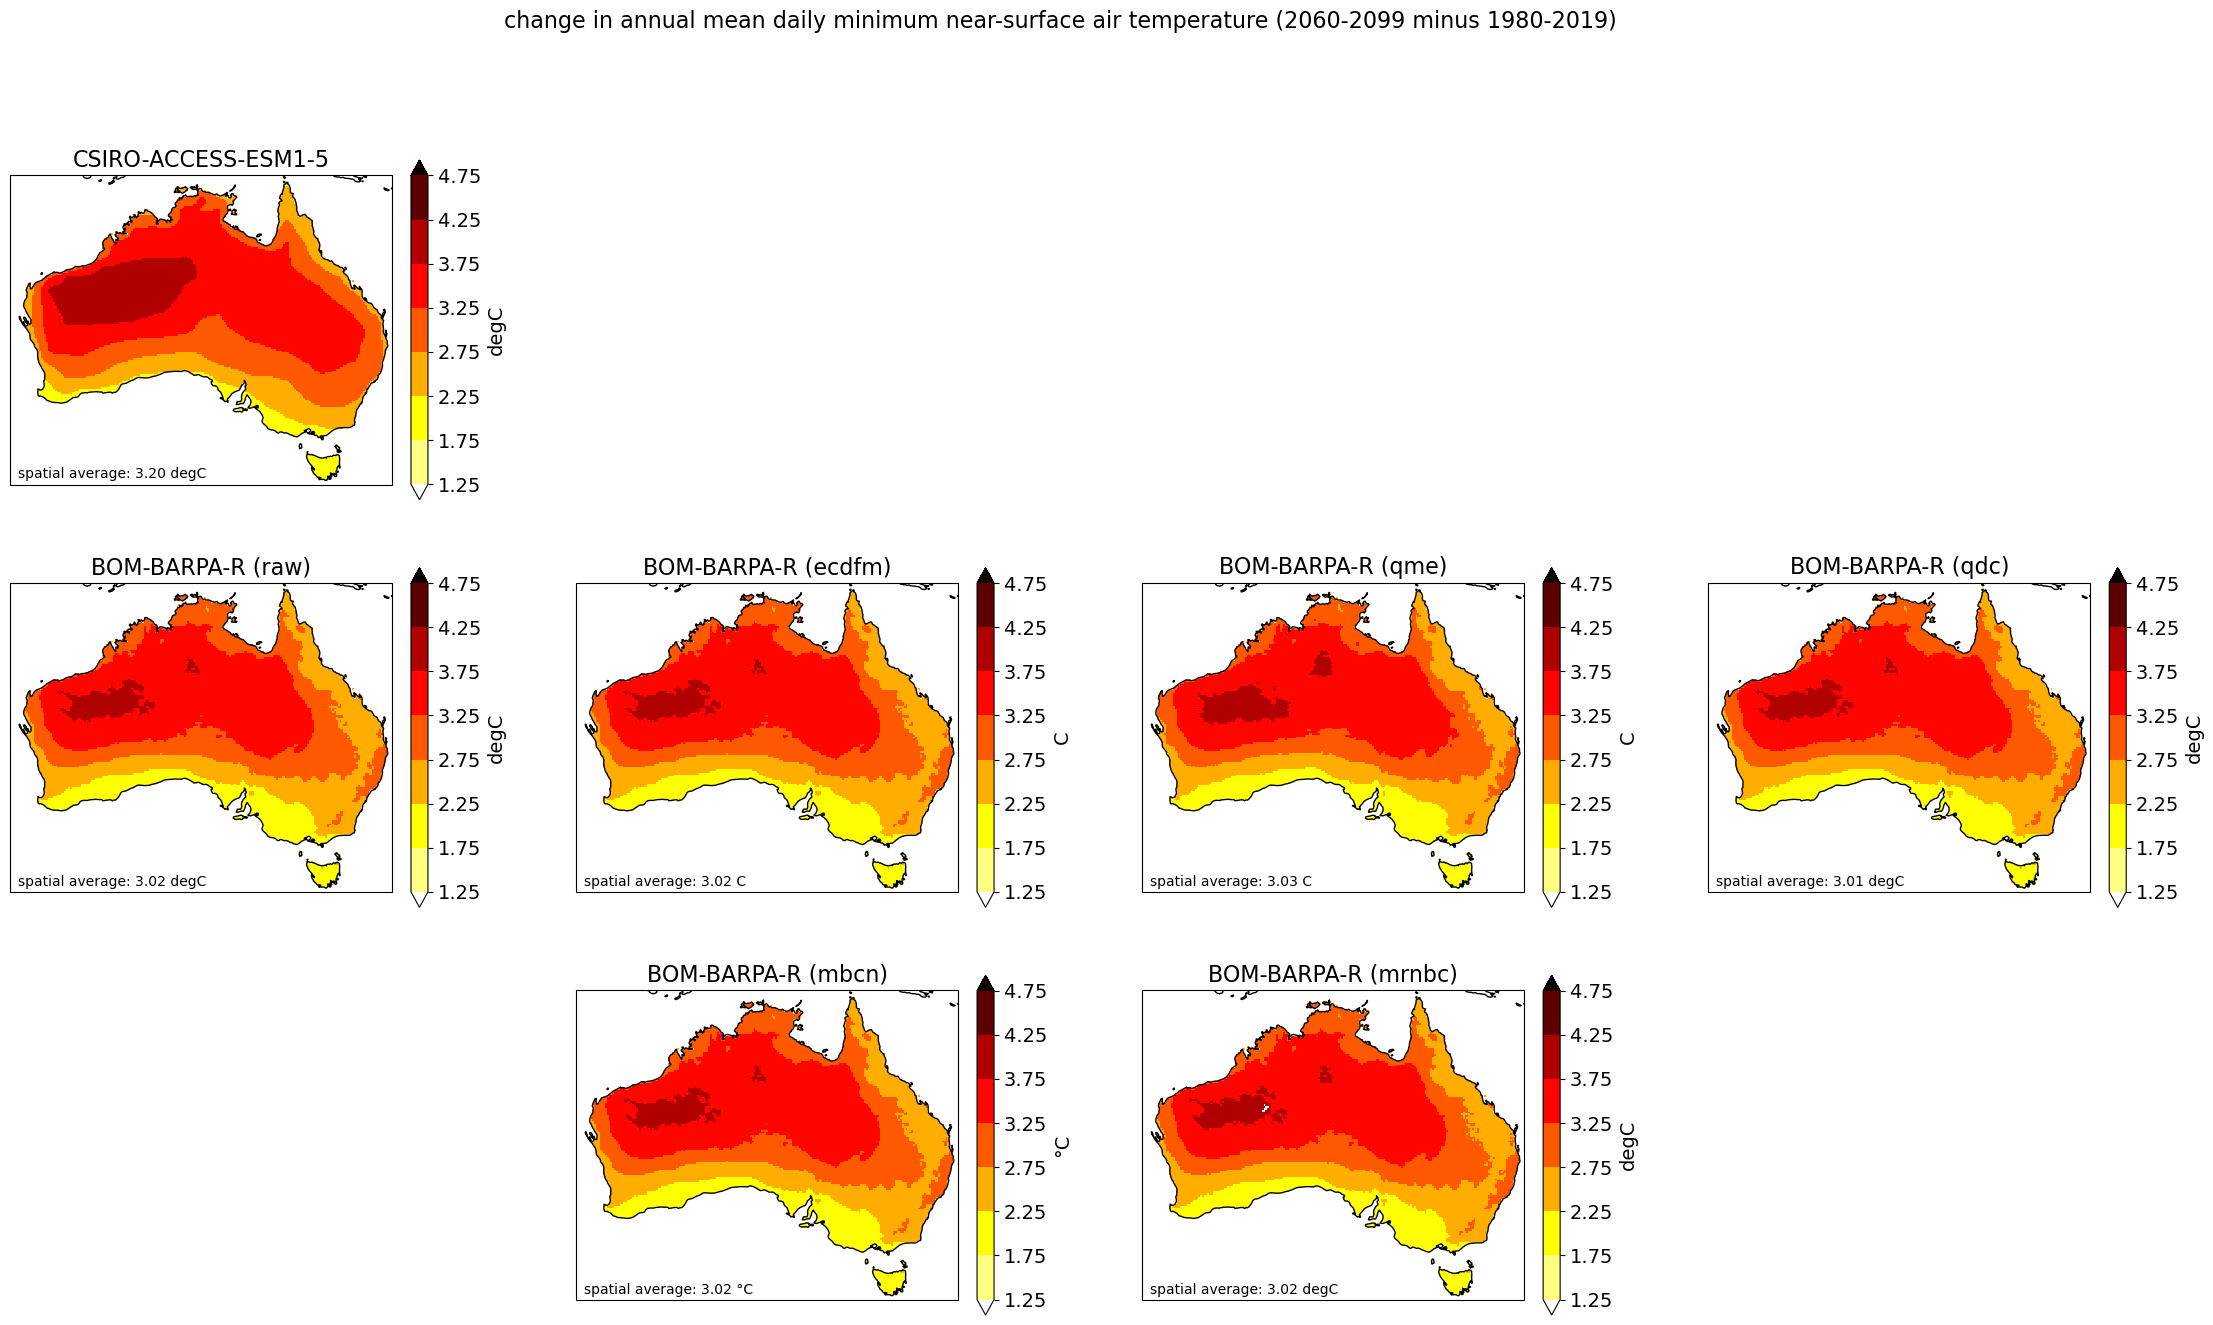

tasmin_trend-rcm_task-projection_CSIRO-ACCESS-ESM1-5_BOM-BARPA-R.png


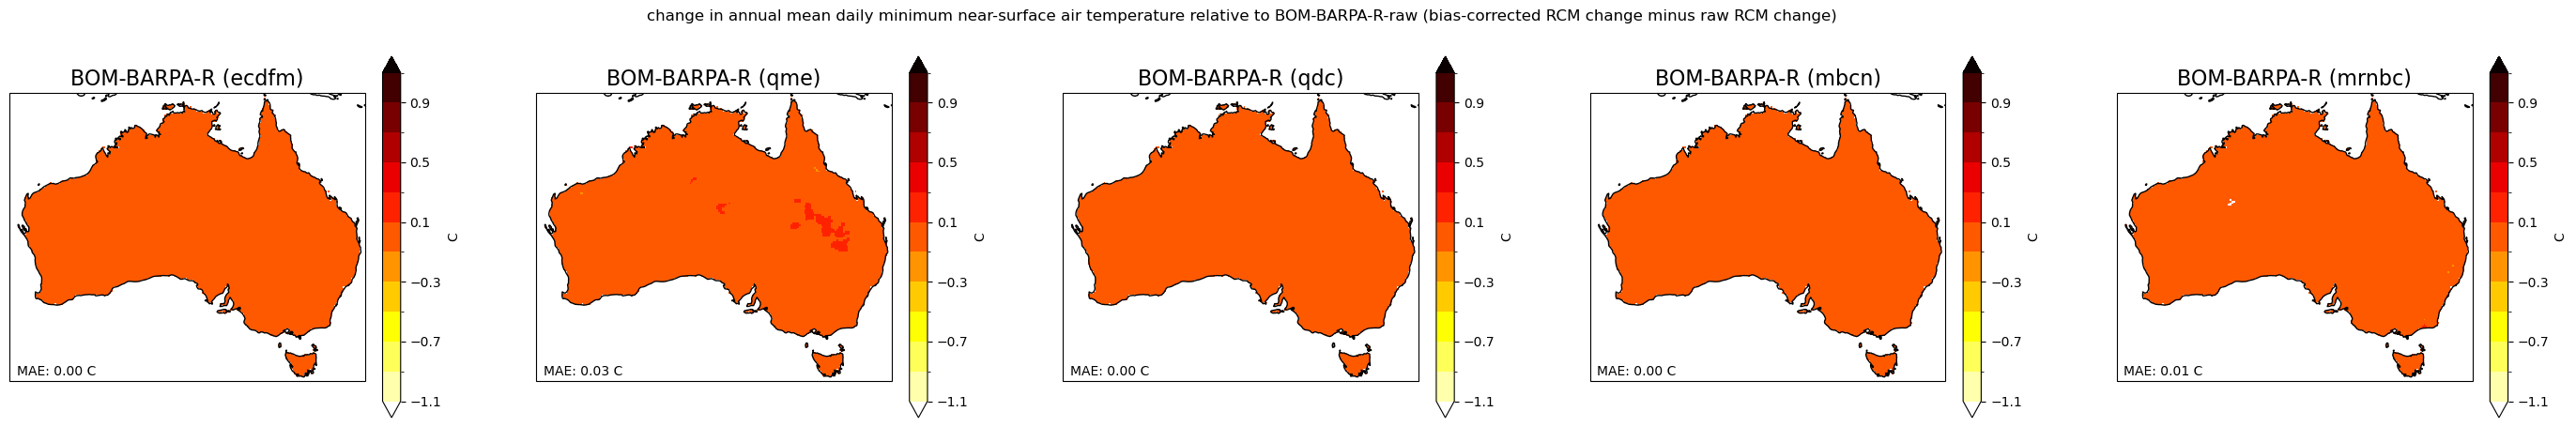

In [7]:
plot_comparison(
    variable,
    'CSIRO-ACCESS-ESM1-5',
    'BOM-BARPA-R',
    cmap,
    levels,
    rcm_levels,
    outfile=f'{variable}_trend_task-projection_CSIRO-ACCESS-ESM1-5_BOM-BARPA-R.png',
    rcm_outfile=f'{variable}_trend-rcm_task-projection_CSIRO-ACCESS-ESM1-5_BOM-BARPA-R.png',
)

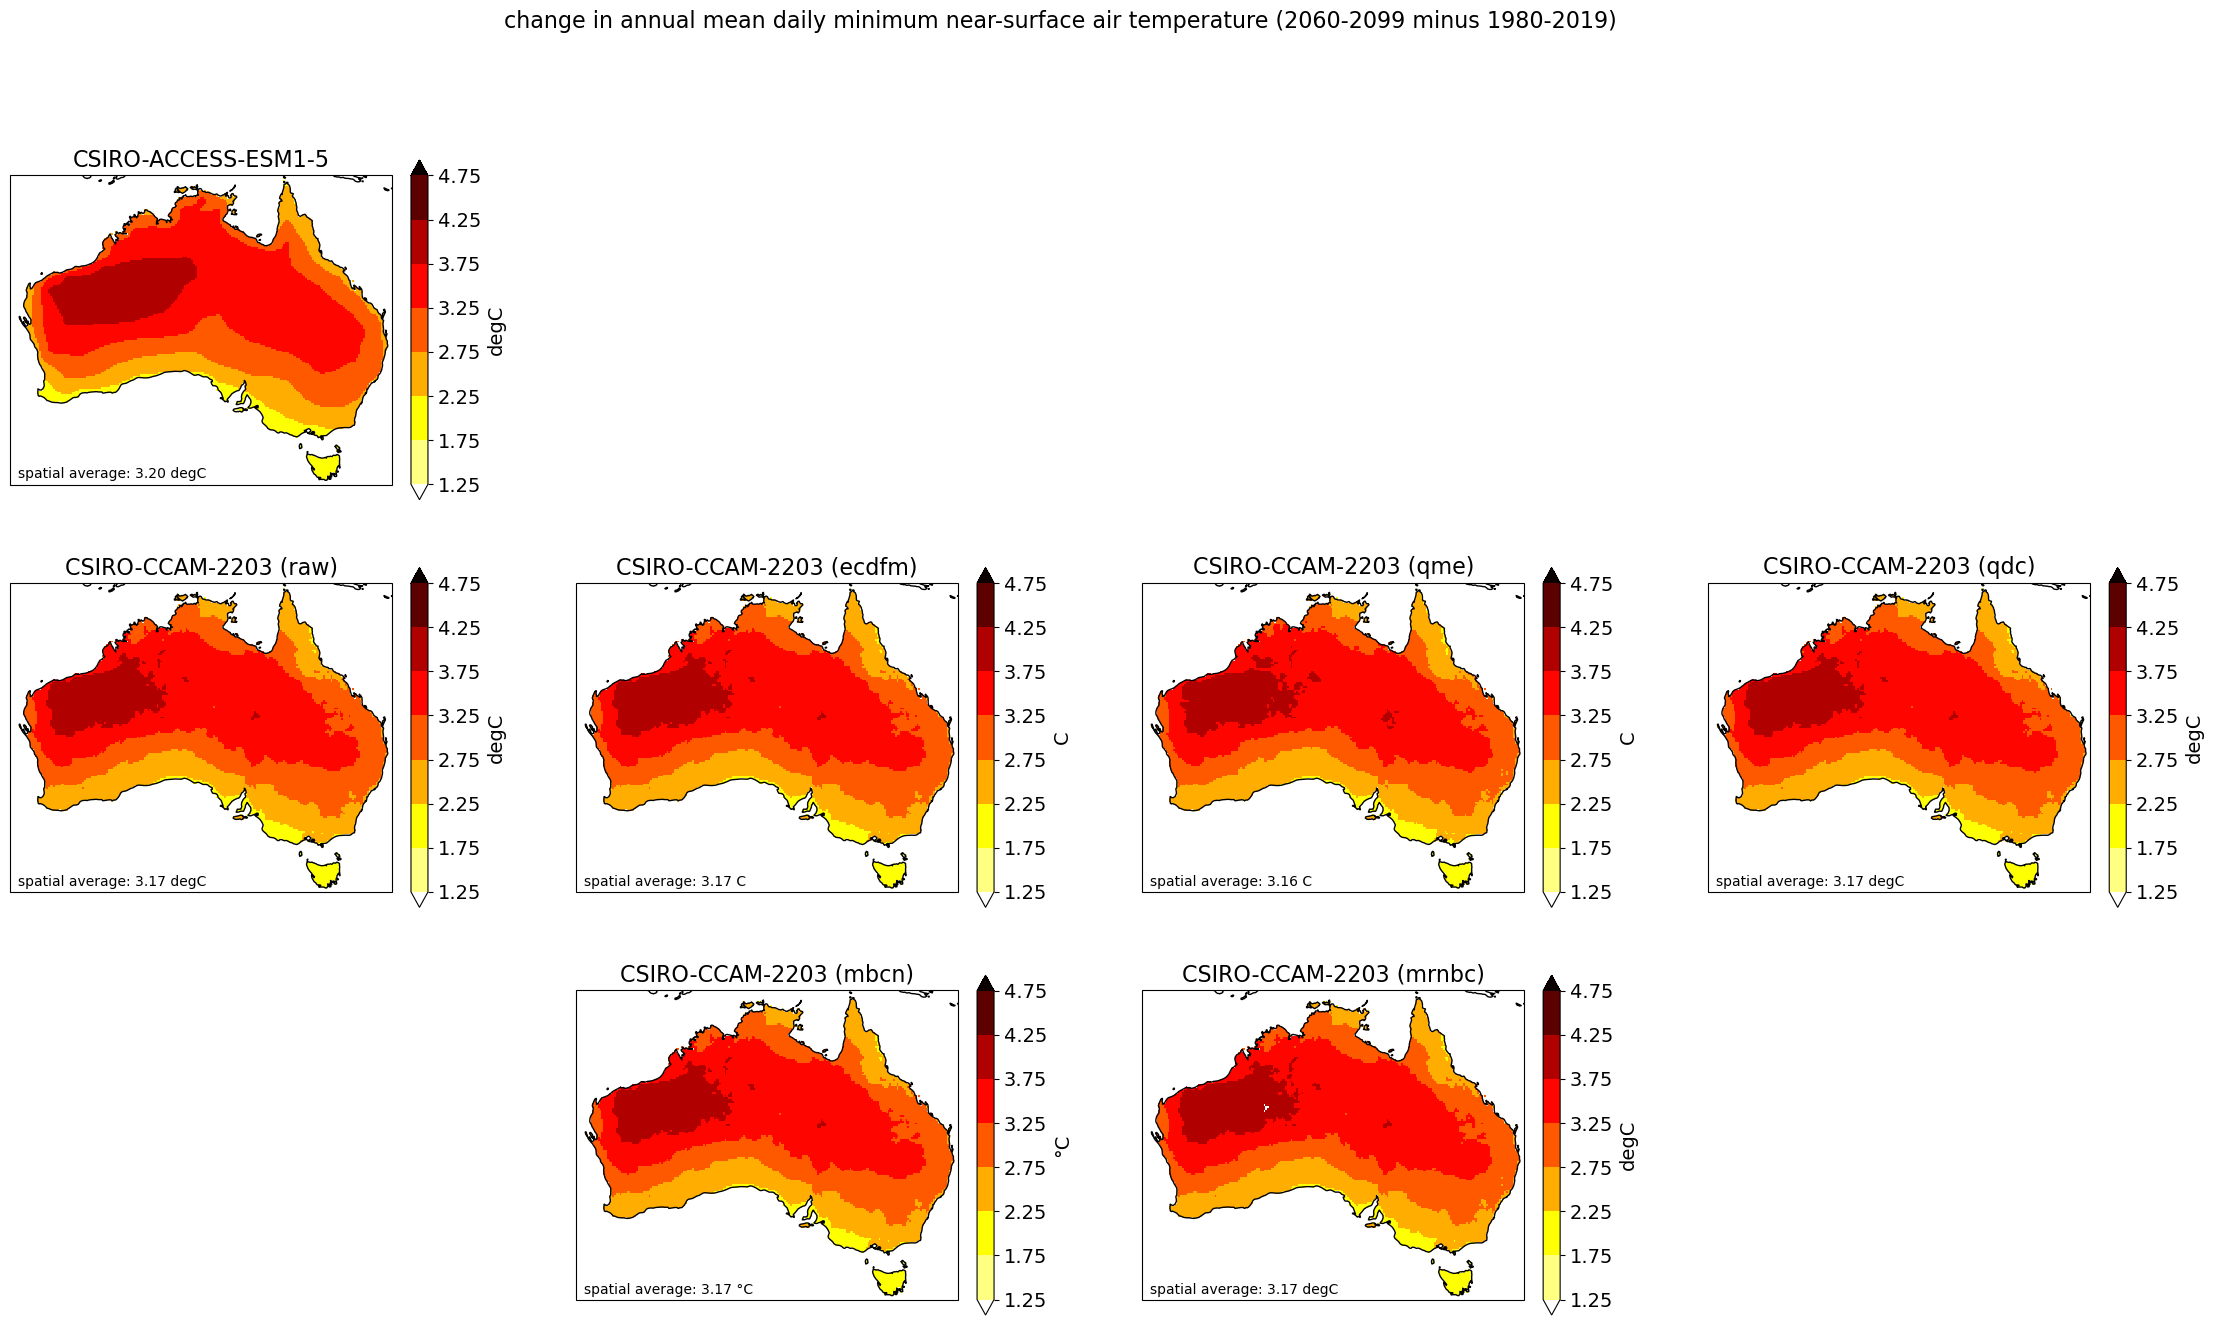

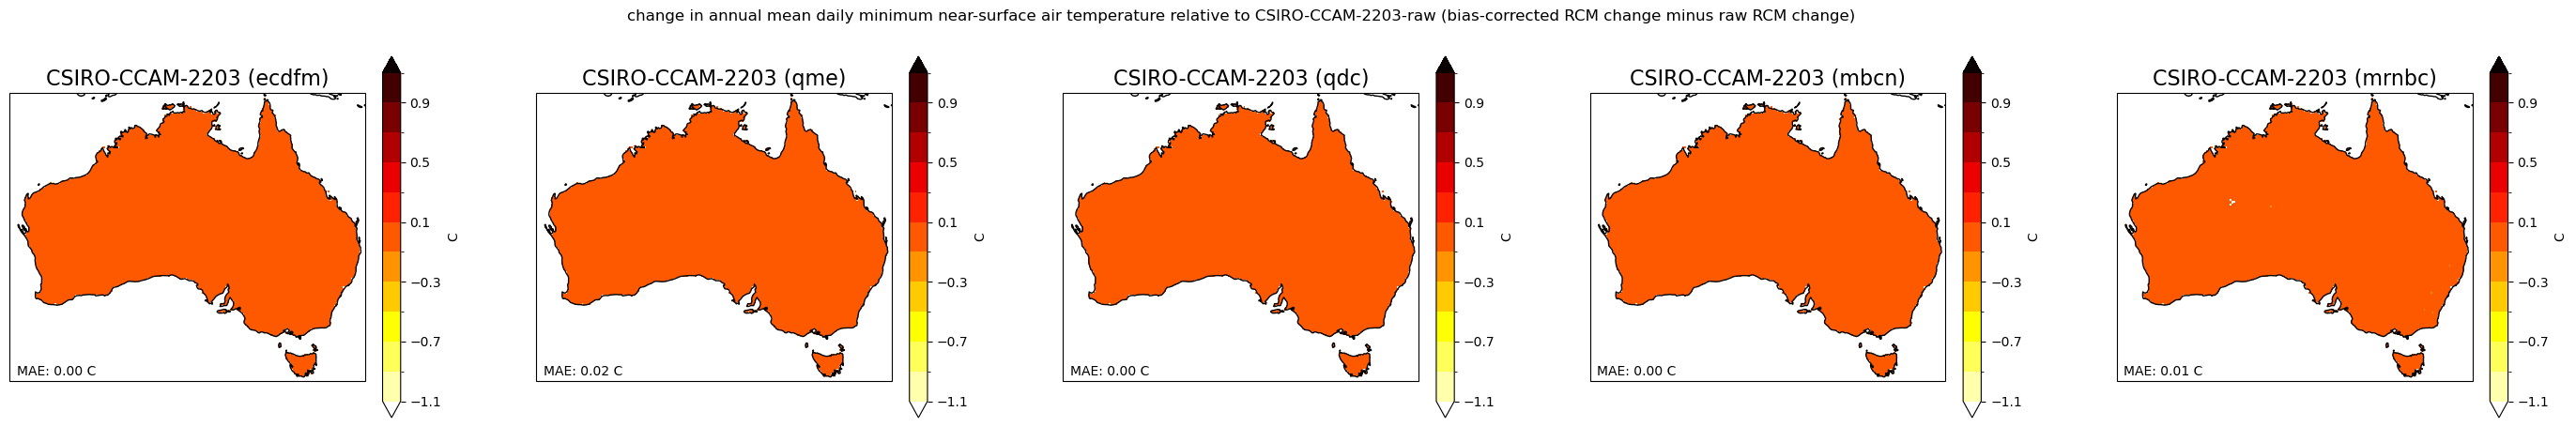

In [8]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', cmap, levels, rcm_levels)

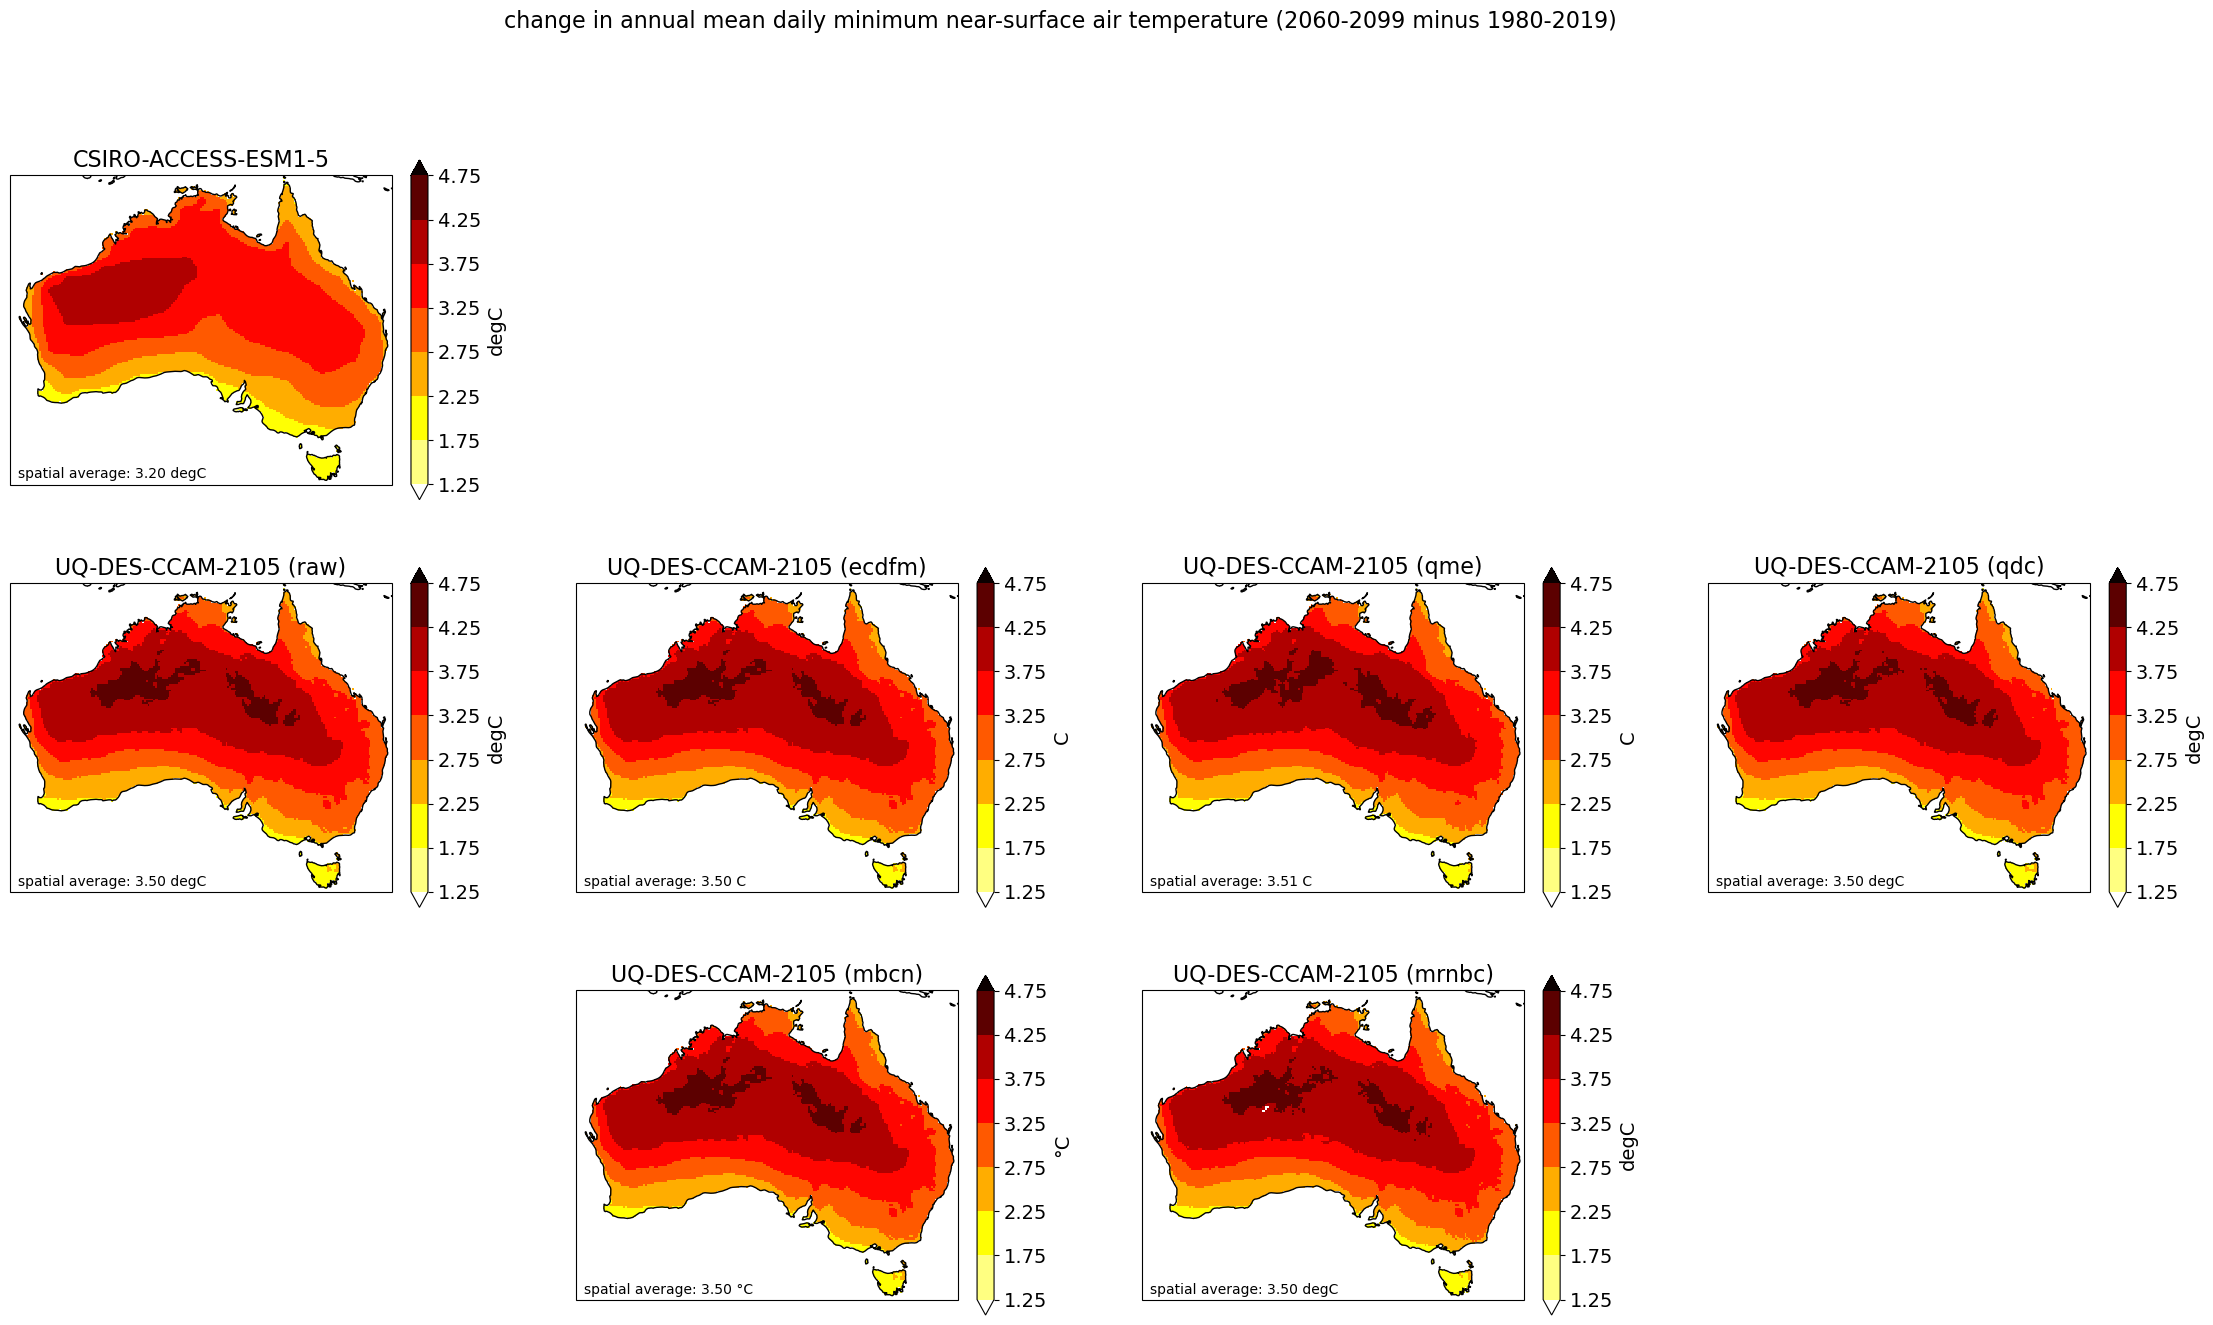

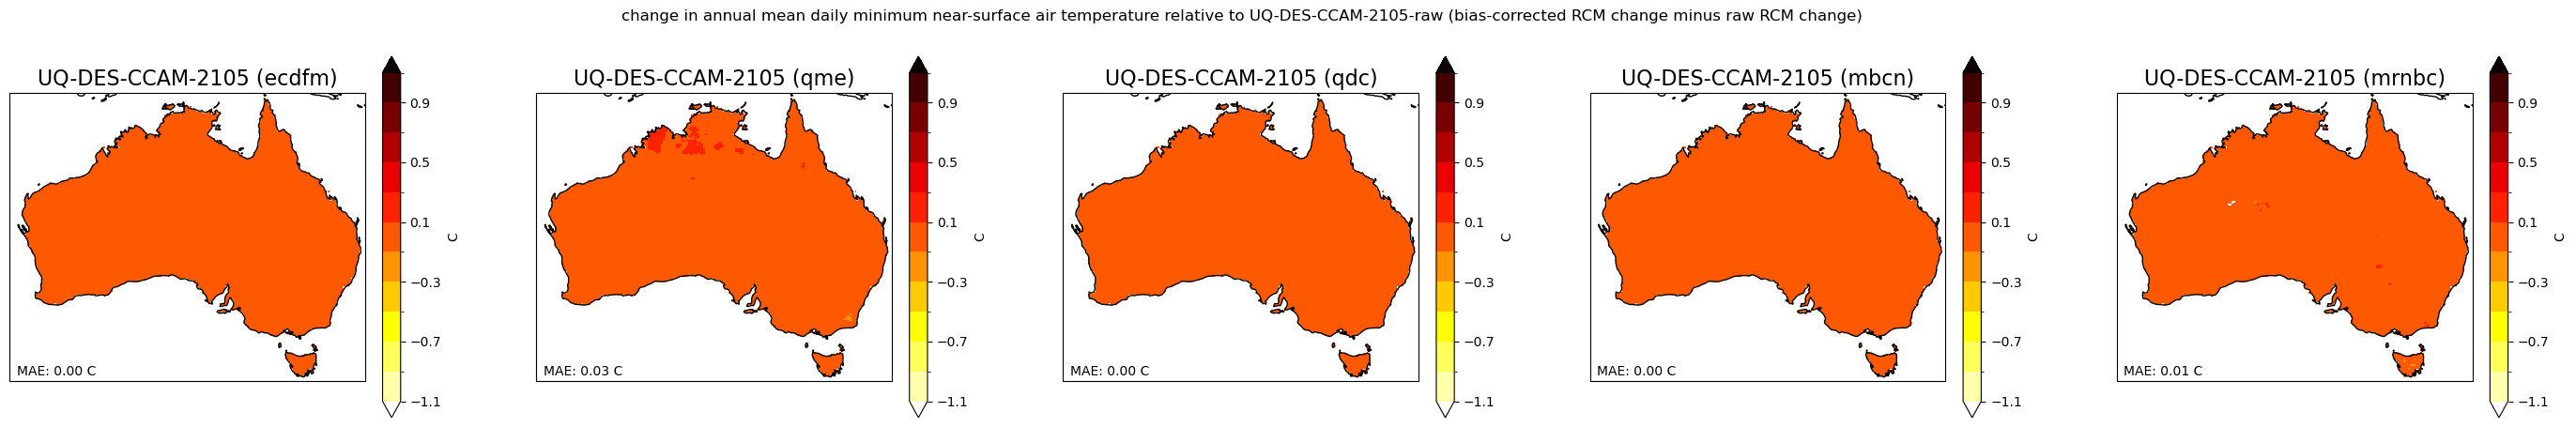

In [9]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', cmap, levels, rcm_levels)